# 6. Decision Trees

**在决策树中，最能区分类别的特征将作为最先判断的条件，然后依次向下判断各个次优特征**。决策树的核心就在于如何选取每个节点的最优判断条件，也即特征选择的过程。而在每一个判断节点，决策树都会遵循一套if-then的规则：

与SVM一样，决策树是多功能的机器学习算法，

* 可以执行分类和回归任务，甚至是多输出任务。 
* 它们是非常强大的算法，能够拟合复杂的数据集。例如，在第2章中，您在加州住房数据集上训练了一个DecisionTreeRegressor模型，使其完美拟合（实际上过拟合了）。
* 决策树也是随机森林的基本组成部分（参见第7章），这是最强大的机器学习算法之一

今天。在本章中，我们将
* 首先讨论如何训练，可视化和使用决策树进行预测。
* 然后我们将介绍Scikit-Learn使用的CART训练算法，我们将讨论如何规范树木并将其用于回归任务。 
* 最后，我们将讨论决策树的一些局限性。

### Setup

In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "06_Decision Trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
    
# Ignore useless warnings (see SciPy issue #5998)
# 忽略无用警告
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 6.1 Training and Visualizing a Decision Tree

要理解决策树，让我们构建一个决策树并查看它是如何进行预测。 以下代码在iris数据集上训练DecisionTreeClassifier（见第4章）：

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:,2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

你可以通过使用**export_graphviz（）**方法输出名为**iris_tree.dot**的图形定义文件来可视化训练好的决策树：

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=image_path("iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

然后，你可以使用graphviz包中的dot命令行工具将此**.dot**文件转换为各种格式，如PDF或PNG。下面这条命令行将.dot文件转换为.png图像文件：

$ dot -Tpng iris_tree.dot -o iris_tree.png



windows下使用安装Graphviz:

下载安装包：https://graphviz.gitlab.io/_pages/Download/Download_windows.html

使用：

https://www.cnblogs.com/shuodehaoa/p/8667045.html

https://www.jianshu.com/p/6d9bbbbf38b1

https://blog.csdn.net/lanchunhui/article/details/49472949

https://blog.csdn.net/qq_41185868/article/details/79008351

下面的代码是把生成的iris_tree.png 显示出来，具体可以参考：[Jupyter Notebook插入图片的4种方法](https://blog.csdn.net/qq_33039859/article/details/78507316)

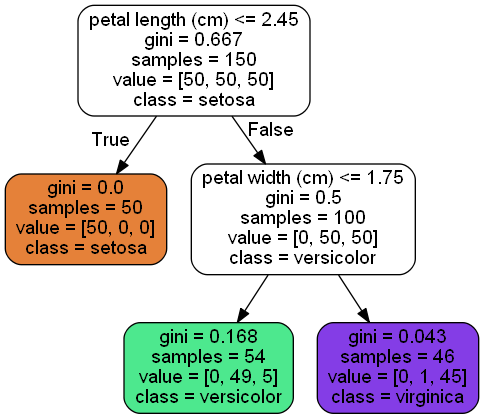

In [14]:
# 你的第一个决策树长这样
from IPython.display import Image
Image(filename=
      "F:/ML/Machine learning/Hands-on machine learning with scikit-learn and tensorflow/images/06_Decision Trees/iris_tree.png",
      width=400,height=400,)

### 6.2 Making Predictions

让我们看看图6-1(即上图)中表示的树是如何进行预测的。

* 假设您找到了鸢尾花，并且您想对其进行分类。从根节点（深度0，顶部）开始：此节点询问**花瓣的长度是否小于2.45厘米**：
    
    * 如果是，则向下移动到根的左子节点（深度1，左）。在这种情况下，它是一个  叶子节点（即，它没有任何子节点），因此它不会问任何问题：您可以简单地查看该节点的预测类，并且决策树预测您的花是Iris-Setosa（ class = setosa）。


* 现在假设你找到了另一朵花，但这次花瓣的长度大于2.45厘米。您必须向下移动到根的右子节点（深度1，右侧），即它不是一个叶子节点，所以它问另一个问题：**花瓣宽度是否小于1.75厘米**：
    
    * 如果是，那么你的花很可能是Iris-Versicolor（深度2，左）。
    
    * 如果没有，很可能是Iris-Virginica（深度2，右）。这真的很简单。

决策树的许多特性之一是它们只需要很少的数据准备。特别是，它们**根本不需要特征缩放或居中**。

1. 节点的**samples**属性计算它适用的训练实例数。例如，100个训练实例的花瓣**长度**大于2.45厘米（深度1，右），其中54的花瓣**宽度**小于1.75厘米（深度2，左）。

2. 节点的**value**属性告诉我们此节点适用于每个类的训练实例数：例如，右下角节点适用于0 Iris-Setosa，1 Iris-Versicolor和45 Iris-Virginica。

3. 最后，节点的**gini**属性测量其**impurity**：如果节点应用的所有训练实例属于同一个类，则该节点为“纯”（gini = 0）。 例如，由于深度为 -1 的左节点仅适用于Iris-Setosa训练实例，因此它是纯粹的并且其**gini**评分为0。

公式6-1显示了训练算法如何计算第i个节点的**gini**评分$G_i$。 例如，深度为2的左节点的**gini**评分等于

 $ 1 - (0/54)^2 - (49/54)^2 - (5/54)^2≈0.168$。 不久将讨论另一种**impurity measure**。
 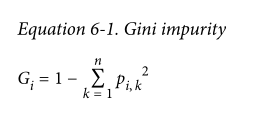

其中，$p_{i,k}$是类别k实例的实例数，在第i个节点的所有训练实例中所占的比例。

Saving figure decision_tree_decision_boundaries_plot


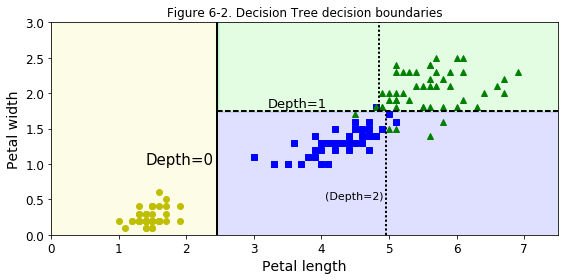

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.title('Figure 6-2. Decision Tree decision boundaries')

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

Scikit-Learn使用CART算法，该算法仅生成二叉树：非叶节点总是有两个子节点（即，问题只有是/否答案）。 但是，其他算法（如ID3）可以生成具有两个以上子节点的节点的决策树。

图6-2显示了决策树的决策边界。

* **粗垂直线**表示根节点的决策边界（深度0）：花瓣长度= 2.45厘米。由于左侧区域是纯净的（仅Iris-Setosa），因此无法进一步拆分。 

* 然而，右侧区域是不纯的，因此深度为1的右侧节点将其分割成花瓣宽度= 1.75厘米（由**虚线**表示）。由于max_depth设置为2，因此决策树会在那里停止。 

* 但是，如果将max_depth设置为3，那么两个深度为2的节点将各自添加另一个决策边界（由**点虚线**表示）。

**模型解读：白盒与黑盒**

正如您所见，**决策树非常直观**，而且他们的决策很容易解释。 这种模型通常被称为**白盒模型**。 相反，正如我们将要看到的，**随机森林或神经网络**通常被认为是**黑盒模型**。 他们做出了很好的预测，你可以轻松地检查他们进行的计算以做出这些预测; 尽管如此，通常很难用简单的术语解释为什么做出预测。 例如，如果一个神经网络说一个特定的人出现在一张图片上，那么很难知道这个预测究竟有什么贡献：模型是否认出了那个人的眼睛？ 她的嘴？ 她的鼻子？ 她的鞋子？ 甚至是她坐在沙发上？ 相反，决策树提供了简单的分类规则，如果需要，甚至可以手动应用（例如，用于花卉分类）。

### 6.3 Estimating Class Probabilities

**估计类概率**
决策树也可以估计一个实例属于一个特定的类 k 的概率：首先它遍历树以找到该实例的叶节点，然后它返回该节点中类 k 的训练实例的**比例**。
例如，假设你发现了一朵花瓣长5厘米，宽1.5厘米的花。 相应的叶节点是深度为2的左节点，因此决策树应输出以下概率：
* Iris-Setosa 为 0％（0/54），
* Iris-Versicolor 为 90.7％（49/54），
* Iris-Virginica 为 9.3％（5/54）。

当然，如果你要求它预测类别，它应该输出Iris-Versicolor（类别 1 ），因为它的概率最高。 我们来检查一下：

In [17]:
tree_clf.predict_proba([[5,1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [18]:
tree_clf.predict([[5,1.5]])

array([1])

请注意，估计的概率在图6-2的右下方矩形中的任何其他位置都是相同的 - 例如，如果花瓣长6厘米，宽1.5厘米（尽管在这种情况下很可能显然是Iris-Virginica）。

### 6.4 The CART Training Algorithm

Scikit-Learn使用**分类和回归树（Classification And Regression Tree-CART）**算法训练决策树（也称为“生长”树）。这个想法非常简单：
该算法首先使用**单个特征 k 和阈值 $t_k$** （例如，“花瓣长度≤2.45cm”）将训练集**分成两个子集**。它如何选择 k 和 $t_k$呢？它为 $(k，t_k)$ 搜索产生最纯子集（按其大小加权）。算法试图最小化的成本函数由公式6-2给出:
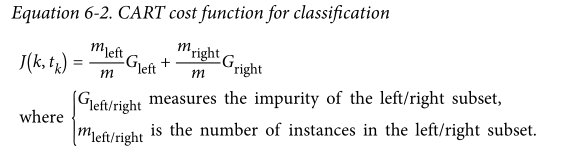

* 一旦它成功地将训练集分成两部分，它就会**使用相同的逻辑分割子集，然后递归地分割子子集等**。
* 一旦达到**最大深度**（由max_depth超参数定义），或者如果找不到会减少杂质的分割，它就会停止递归。
* 其他一些超参数（稍后描述）控制其他停止条件（min_samples_split，min_sam ples_leaf，min_weight_fraction_leaf和max_leaf_nodes）。


如你所见，CART算法是一种贪婪的算法：它贪婪地在顶层搜索最佳分割，然后在每个级别重复该过程。 它不检查分裂是否会导致几个级别的最低可能杂质。 贪心算法通常会产生一个**相当好的解决方案**，**但它不能保证是最佳解决方案**。

不幸的是，找到最佳树是一个NP-Complete问题：它需要$O(exp(m))$时间，即使对于相当小的训练集，问题也难以处理。这就是为什么我们必须满足于“合理的”解决方案。

### 6.5 Computational Complexity

进行预测需要从根到叶子遍历决策树。决策树通常近似平衡，因此遍历决策树需要经过大致$O(log_2(m))$节点。由于每个节点仅需要检查一个特征的值，因此总体预测复杂度仅为$O(log_2(m))$，与特征的数量无关。 因此，即使在处理大型训练集时，预测也非常快。

但是，训练算法会比较所有特征（如果设置了max_features，则会少一点）在每个节点的所有样本上。 这导致训练复杂度为$O(n×m log(m))。
* 对于小型训练集（少于几千个实例），Scikit-Learn可以通过**预先分配数据**来加速训练（设置presort = True），
* 但是对于较大的训练集来说，这会大大减慢训练速度。

### 6.6 Gini Impurity or Entropy?

**基尼杂质或熵?**

默认情况下，使用Gini杂质测量，但您可以通过将标准超参数设置为“熵”选择entropy impurity来测量。熵的概念起源于热力学作为分子紊乱的度量：

当分子仍处于有序状态时，熵接近于零。 它后来传播到各种各样的领域，包括香农的信息理论，它测量消息的平均信息内容：当所有消息相同时，熵为零。 在机器学习中，它经常被用作杂质测量：当一个集合的熵只包含一个类的实例时，它的集合为零。 公式6-3显示了第i个节点的熵的定义。 例如，图6-1中的深度2的左节点具有等于$-\frac{49}{54}log(\frac{49}{54})-\frac{5}{54}log(\frac{5}{54})≈0.31$的熵。
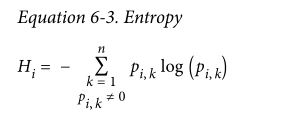

你应该使用基尼杂质还是熵？ 事实是，大部分时间它们并没有产生很大的不同：它们导致类似的树。基尼杂质的计算速度稍快，因此它是一个很好的默认值。 然而，当它们不同时，基尼杂质倾向于在树的自己的分支中隔离最频繁的类，而熵倾向于产生稍微更平衡的树。

**Sensitivity to training set details**

In [19]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [20]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

Saving figure decision_tree_instability_plot


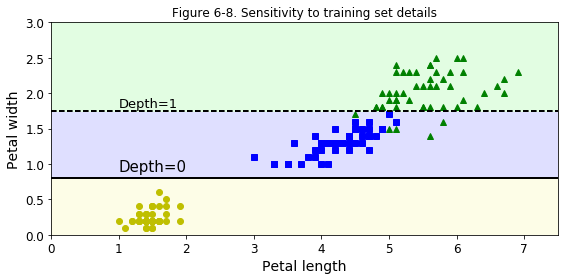

In [44]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.title('Figure 6-8. Sensitivity to training set details')

save_fig("decision_tree_instability_plot")
plt.show()

### 6.7 Regularization Hyperparameters

决策树对训练数据做出很少的假设（与线性模型假设数据是线性的相反）。如果不受约束，树结构将适应训练数据，非常接近它，并且很可能过拟合它。 这样的模型通常被称为**非参数模型**，不是因为它没有任何参数（它通常有很多），**而是因为参数的数量在训练之前没有确定**，所以模型结构可以自由地贴近数据。 相比之下，诸如线性模型的参数模型具有预定数量的参数，因此其自由度受到限制，从而降低了过拟合的风险（但增加了欠拟合的风险）。

为避免过拟合训练数据，你需要在训练期间**限制决策树的自由**。 如你所知，这被称为**正则化**。正则化超参数取决于所使用的算法，但通常您至少可以**限制决策树的最大深度**。 在Scikit-Learn中，这由**超参数max_depth**控制（默认值为None，表示无限制）。**减少max_depth将使模型则化，从而降低过拟合的风险**。

**DecisionTreeClassifier类**还有一些其他参数类似地限制了决策树的形状：

* min_samples_split（节点在分割之前必须具有的最小样本数），

* min_samples_leaf（叶子节点必须具有的最小样本数），

* min_weight_fraction_leaf（与min_samples_leaf相同，但表示为加权实例总数的一部分），

* max_leaf_nodes（叶子节点的最大数量），

* max_features（在每个节点处评估用于拆分的最大特征数）。

* 增加超参数 $min_*$  或减少超参数 $max_*$ 将使模型正规化。

其他算法的工作原理是首先在没有限制的情况下训练决策树，然后修剪（删除）不必要的节点。如果它提供的纯度改善没有统计学意义，子节点都是叶节点的节点被认为是不必要的。标准统计检验，例如$χ^2$ 检验，用于估计改善纯粹是偶然结果的概率（称为零假设）。如果这个概率（称为pvalue）高于给定阈值（通常为5％，由超参数控制），那么该节点被认为是不必要的，并删除其子节点。修剪继续，直到所有不必要的节点都被修剪。

Saving figure min_samples_leaf_plot


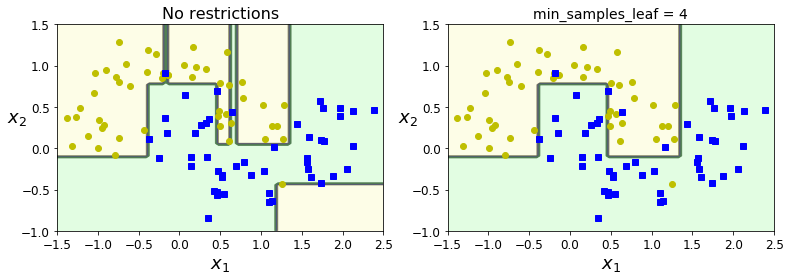

In [38]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

图6-3(即上图)显示了在moons datasets 上训练的两个决策树（在第5章介绍）。在左侧，使用默认超参数训练决策树（即没有限制），在右侧，使用min_samples_leaf = 4训练决策树。很明显，左边的模型是过拟合的，右边的模型可能会泛化的更好。

In [39]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

ValueError: shapes (200,1) and (2,2) not aligned: 1 (dim 1) != 2 (dim 0)

Saving figure sensitivity_to_rotation_plot


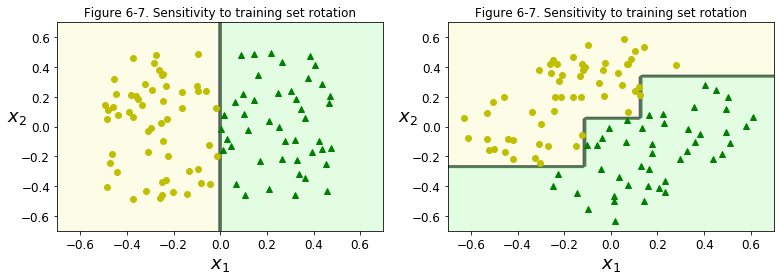

In [43]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.title('Figure 6-7. Sensitivity to training set rotation')

plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.title('Figure 6-7. Sensitivity to training set rotation')

save_fig("sensitivity_to_rotation_plot")
plt.show()

### 6.9 Instability

**不稳定性**(这部分不是按书上的顺序来的，把最后一小节提前了)

希望到现在你确信决策树有很大帮助：它们易于理解和解释，易于使用，功能多样，功能强大。但是他们确实有一些限制。

1. 首先，正如你可能已经注意到的，决策树喜欢正交决策边界（所有分裂都垂直于轴），这使得它们**对训练集旋转敏感**。例如，图6-7显示了一个简单的线性可分离数据集：
   * 在左侧，决策树可以轻松拆分，
   * 在右侧，数据集旋转45°后，决策边界看起来不必要地复杂化。
   
   尽管两个决策树都完美地拟合训练集，但右侧的模型很可能不会很好地泛化。 限制此问题的一种方法是使用PCA（参见第8章），这通常可以更好地定位训练数据。

2. 更一般地说，决策树的主要问题是他们对训练数据中的微小变化非常敏感。例如，如果您只是从鸢尾花训练集（花瓣长4.8厘米，宽1.8厘米）中移除最宽的Iris-Versicolor，并训练一个新的决策树，你可以得到如图6-8所示的模型。如你所见，它与之前的决策树看起来非常不同（图6-2）。由于Scikit-Learn使用的训练算法是随机的，即使在相同的训练数据上也可能得到非常不同的模型（除非你设置了random_state超参数）。

我们将在下一章中看到的随机森林可以通过对许多树的预测进行平均来限制这种不稳定性。

### 6.8 Regression

决策树还能够执行回归任务。让我们使用Scikit-Learn的**DecisionTreeRegressor类**构建一个回归树，在一个有噪声的二次数据集上训练它，max_depth = 2

In [25]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
export_graphviz(
        tree_reg1,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

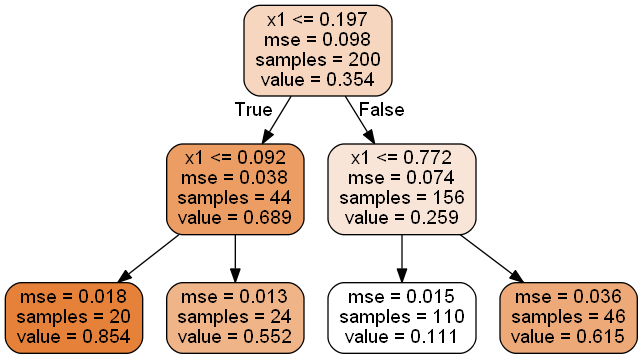

In [34]:
# 你的第二个决策树长这样
from IPython.display import Image
Image(filename=
      "F:/ML/Machine learning/Hands-on machine learning with scikit-learn and tensorflow/images/06_Decision Trees/regression_tree.png",
      width=400,height=400,)

此树看起来与你之前构建的分类树非常相似。**主要区别在于，它不是预测每个节点中的类，而是预测一个值**。例如，假设您要对$x_1 = 0.6$的新实例进行预测。 您从根开始遍历树，最终到达 predicts value = 0.111 的叶节点。 **该预测仅仅是与该叶节点相关联的110个训练实例的平均目标值**。 在这110个实例中，该预测导致均方误差（MSE）等于0.0151。

该模型的预测显示在图6-5的左侧。如果设置max_depth = 3，则会获得右侧所示的预测。请注意**每个区域的预测值始终是该区域中实例的平均目标值**。该算法以使得大多数训练实例尽可能接近该预测值的方式分割每个区域。

Saving figure tree_regression_plot


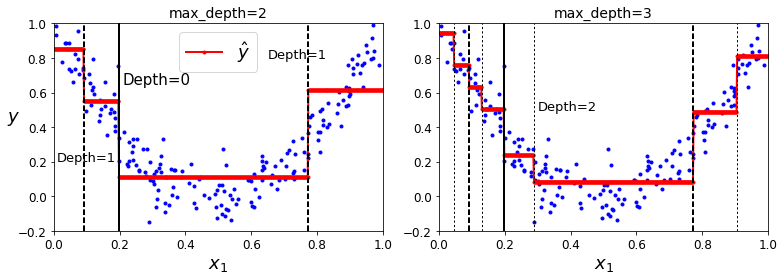

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)

plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)

plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

CART算法的工作方式与之前大致相同，除了试图**以最小化杂质的方式分割训练集**之外，它现在尝试**以最小化MSE的方式分割训练集**。 公式6-4显示了算法尝试最小化的成本函数:
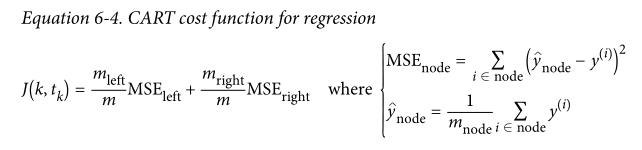

Saving figure tree_regression_regularization_plot


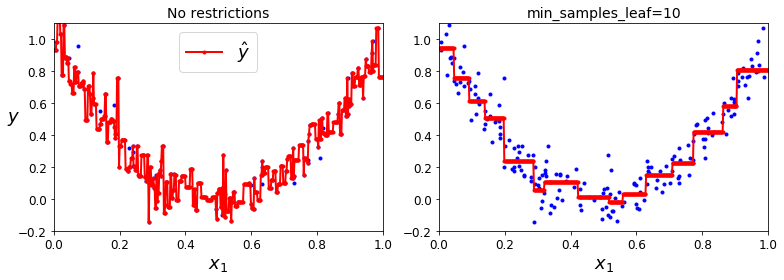

In [32]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

就像**分类任务**一样,决策树在处理**回归任务**时容易过拟合。如果没有任何正则化（即使用默认的超参数），您将获得图6-6左侧的预测。
显然，这对训练集来说非常严重。只需设置**min_samples_leaf = 10**即可得到更合理的模型，如图6-6右侧所示。

### Exercises

**1.to 6.**
请移步我的简书[Chapter - 6 Exercise(1- 6)](https://www.jianshu.com/p/8ccb47c541e4)

#### 7.

练习：使用moos 数据集训练和微调决策树。

**a.** 使用make_moons(n_samples=10000, noise=0.4).产生一个moons 数据集

使用random_state=42 确保笔记本的输出一致：

In [45]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

**b.** 使用train_test_split()划分训练集和测试集

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**c.** 使用带有**交叉验证的网格搜索**（借助 **GridSearchCV类**）为DecisionTreeClassifier查找好的超参数值。 **提示**：尝试max_leaf_nodes的各种值。

In [47]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1)

grid_search_cv.fit(X_train, y_train)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    4.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [2, 3, 4], 'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
   

In [48]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=17,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

**d.** 使用这些超参数在完整的训练集上训练它，并在测试集上测量模型的性能。 你应该得到大约85％到87％的准确率。

默认情况下，GridSearchCV会训练整个训练集中找到的最佳模型（您可以通过设置**refit = False**来更改此模型），因此我们不需要再次执行此操作。 我们可以简单地评估模型的准确性：

In [49]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

#### 8.
练习：栽种一个森林

**a.** 继续上一个练习，生成1,000个训练集子集，每个子集包含随机选择的100个实例。提示：你可以使用Scikit-Learn的ShuffleSplit类。

In [50]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

**b.** 使用上面找到的最佳超参数值，在每个子集上训练一个决策树。 在测试集上评估这1,000个决策树。 **由于它们是在较小的集合上训练的**，因此这些决策树可能比第一个决策树表现更差，准确率仅达到约80％。

In [51]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

**c.** 下面是见证奇迹的时刻。 对于每个测试集实例，生成1,000个决策树的预测，并仅保留最频繁的预测(你可以使用SciPy的 mode()函数)。
这为你提供了对测试集的多数投票预测。

In [52]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [53]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

**d.** 在测试集上评估这些预测：你应该获得比第一个模型稍高的精度（大约高0.5到1.5％）。 恭喜你已经训练好了了第一个随机森林分类器！

In [55]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872